In [1]:
# https://www.kaggle.com/code/puru98/federated-learning-pytorch
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

c:\Users\Kami\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\cuda\__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [5]:
train_dataset = MNIST('/kaggle/working', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('/kaggle/working', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

In [33]:
# Define Notebook Constants
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784
# firstly, we selected the value of round = 30. after round = 20 the amount of the accuracy and the lost stayed unchangeable. early stopping
num_clients = 8
rounds = 20
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [19]:
total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

In [20]:
# Define utilities for GPU support

def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [34]:
# The server provides several application programming interfaces (APIs) for communication with a client, and performs federated averaging (FedAVG), 
# the server calculates the weighted averages. 
# FedAVG is a widely used optimization algorithm
# FedAVG calculates the average value when the local weights collected from the client reach a specific level. 
# The implemented code was deployed and managed in AWS Beanstalk

# **************************************************
# We conducted four different experiments according to :
# 1-basic, 2-imbalanced, 3-skewed, and a 4-combination of imbalanced and skewed data distributions. 
# The communication assumes that all clients (hospitals) are always powered (as is the case for a typical computer but not for a mobile device) and that their online status is maintained by a wired network connection. 
# In addition, rather than selecting clients via an eligibility criterion from multiple client pools (thousands or millions), the code was implemented to manage a predefined fixed number of clients. 
# In other words, all clients could participate in each round.
# The proposed approach was evaluated on the MNIST dataset in four different experiments.

In [21]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}
    
    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out
    
    def get_track_layers(self):
        return self.track_layers
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data, 
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [22]:
# Define Client class

class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

In [ ]:
# In FL, training is performed at the individual client level.
# then the local weights of each client are sent to the server. 
# The server collects the updated local weights and calculates the new global weights. 
# Subsequently, the client downloads the global weights from the server and continues the training process.
# initial weight and bias values for intial train process are zero

In [23]:
# Setup clients

examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client, 
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [24]:
# Start server

global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)
    
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 0.5162, Accuracy = 0.8455
client_1: Loss = 0.5368, Accuracy = 0.8388
client_2: Loss = 0.4985, Accuracy = 0.8453
client_3: Loss = 0.5164, Accuracy = 0.8449
client_4: Loss = 0.5016, Accuracy = 0.8509
client_5: Loss = 0.5262, Accuracy = 0.8385
client_6: Loss = 0.5265, Accuracy = 0.8417
client_7: Loss = 0.5229, Accuracy = 0.8438
After round 1, train_loss = 0.4134, dev_loss = 0.424, dev_acc = 0.8781

Start Round 2 ...
client_0: Loss = 0.3326, Accuracy = 0.9009
client_1: Loss = 0.3236, Accuracy = 0.9073
client_2: Loss = 0.3088, Accuracy = 0.9096
client_3: Loss = 0.3325, Accuracy = 0.9044
client_4: Loss = 0.3147, Accuracy = 0.9085
client_5: Loss = 0.326, Accuracy = 0.9047
client_6: Loss = 0.3421, Accuracy = 0.9018
client_7: Loss = 0.3359, Accuracy = 0.9004
After round 2, train_loss = 0.2965, dev_loss = 0.3054, dev_acc = 0.9117

Start Round 3 ...
client_0: Loss = 0.2433, Accuracy = 0.9269
client_1: Loss = 0.246, Accuracy = 0.9299
client_2: Loss = 0.2316, Accu

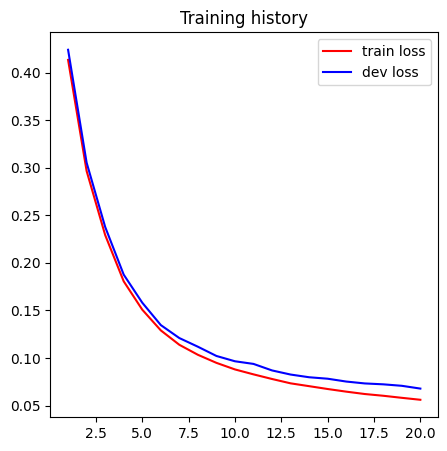

In [25]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

In [26]:
# Save the model state dictionary to a file
torch.save(global_net.state_dict(), 'federated_model')

In [27]:
# # Load model state dict
# import torchvision
# model = torchvision.models.wide_resnet50_2(pretrained=True)

# for param in model.parameters():
#     param.required_grad = False


# model.load_state_dict(torch.load('F:/NAVA/Federated Learning for MNIST/federated_model')) # path of your weights
# model.eval()

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming global_net is your trained model
# Assuming test_dataset is your test dataset

def predict(model, dataset):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for images, labels in DataLoader(dataset, batch_size=batch_size):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

predictions, true_labels = predict(global_net, test_dataset)
conf_matrix = confusion_matrix(true_labels, predictions)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 971    1    1    0    0    1    1    2    2    1]
 [   0 1127    2    2    0    1    1    2    0    0]
 [   3    3 1015    1    1    0    0    6    3    0]
 [   1    0    3  996    0    2    0    5    2    1]
 [   1    0    2    0  972    0    1    1    1    4]
 [   1    0    1    6    0  880    2    1    1    0]
 [   6    4    2    1    3    5  936    0    1    0]
 [   1    4   10    4    0    0    0 1003    1    5]
 [   3    0    4    4    2    1    1    8  947    4]
 [   4    5    1    5    3    3    0    2    0  986]]


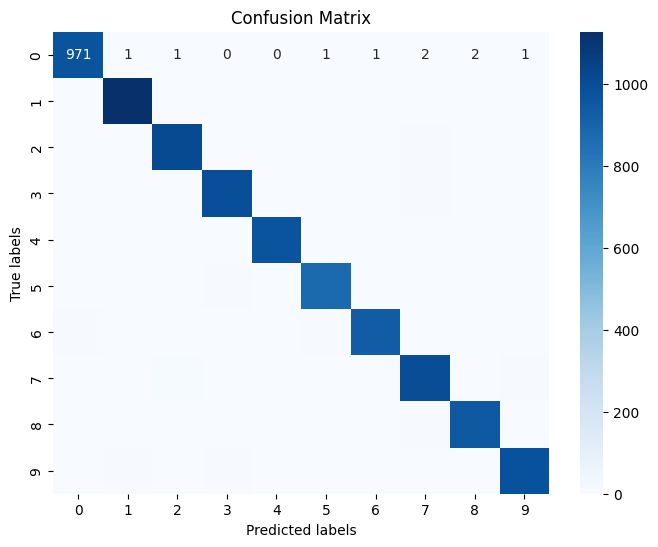

In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming global_net is your trained model
# Assuming test_dataset is your test dataset

def predict(model, dataset):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for images, labels in DataLoader(dataset, batch_size=batch_size):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

predictions, true_labels = predict(global_net, test_dataset)
conf_matrix = confusion_matrix(true_labels, predictions)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

AUROC Scores:
[0.9999096112946287, 0.999841777419988, 0.9997797941345282, 0.9997455919118052, 0.999897692734016, 0.9998364174007573, 0.9998271808803177, 0.9996891539783954, 0.9996403272135119, 0.9995676769159866]


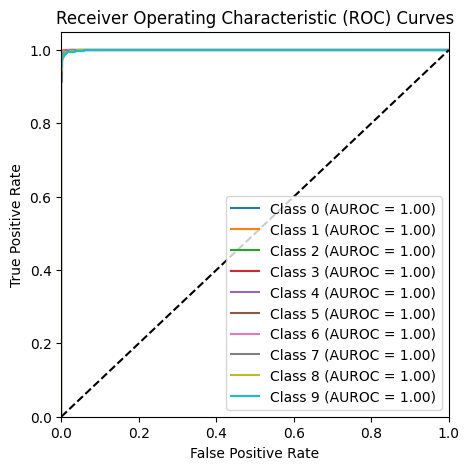

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming global_net is your trained model
# Assuming test_dataset is your test dataset

def predict_proba(model, dataset):
    model.eval()
    probabilities = []
    true_labels = []
    
    with torch.no_grad():
        for images, labels in DataLoader(dataset, batch_size=batch_size):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(probabilities), np.array(true_labels)

# Calculate probabilities and true labels
probabilities, true_labels = predict_proba(global_net, test_dataset)

# Calculate AUROC for each class
classes = np.unique(true_labels)
auroc_scores = []
for i in classes:
    fpr, tpr, _ = roc_curve(true_labels == i, probabilities[:, i])
    auroc = auc(fpr, tpr)
    auroc_scores.append(auroc)

print("AUROC Scores:")
print(auroc_scores)

# Plot ROC curves for each class
plt.figure()
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(true_labels == class_label, probabilities[:, class_label])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUROC = {auroc_scores[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
